# 1 - Feature Extraction

### Loading required libraries

In [21]:
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


### Providing the path to the data

In [3]:

# Input files
raster_loc = 'materials/rasters/s2image.tif'
points_loc = 'materials/shapefiles/samples.shp'
temp_point_loc = 'materials/temp/temp_y_points.shp'

# LULC classes
lulc_name = ['Water', 'Dense Veg', 'Veg', 'Urban']

### Loading  data

### Visualizing the data

In [4]:
src = rio.open(raster_loc)

blue = src.read(1, masked=True)
green = src.read(2, masked=True)
red = src.read(3, masked=True)
nir = src.read(4, masked=True)

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)
nirn = normalize(nir)

c:\Users\sisly\Documents\HYPSO\code\myenv\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


### RGB Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.4e+38].


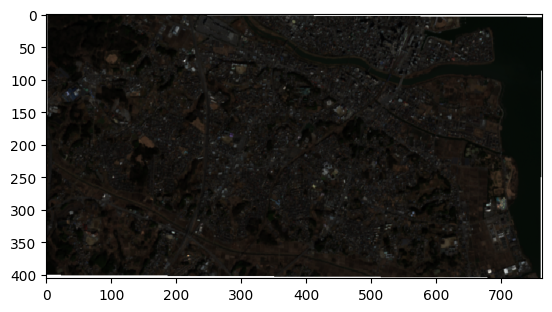

In [5]:
rgb = np.dstack((redn, greenn, bluen))

plt.imshow(rgb)

### False Color Composite Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.4e+38].


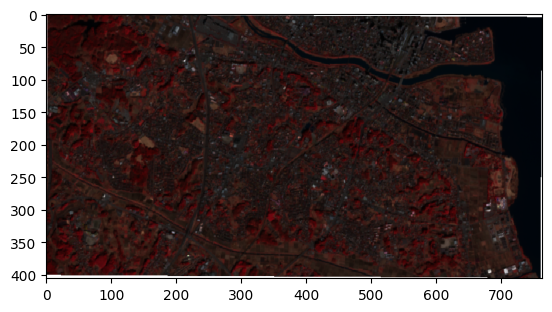

In [6]:
nrg = np.dstack((nirn, redn,greenn))

plt.imshow(nrg)

### NDVI plot

c:\Users\sisly\Documents\HYPSO\code\myenv\lib\site-packages\numpy\ma\core.py:1020: RuntimeWarning: overflow encountered in add
  result = self.f(da, db, *args, **kwargs)


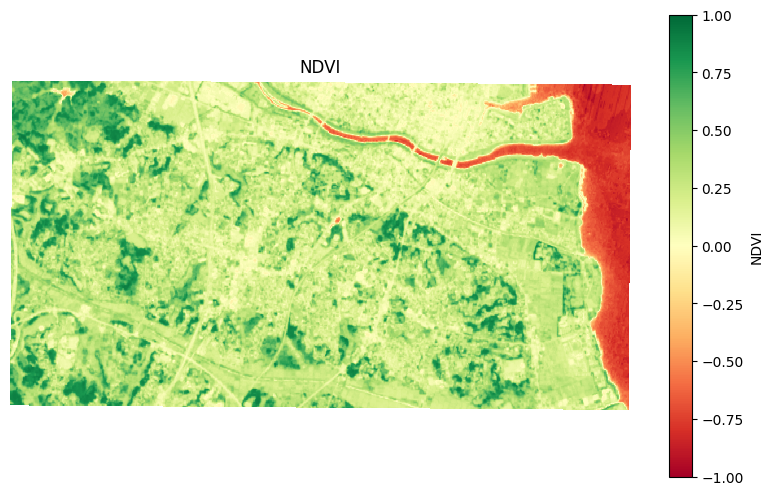

In [ ]:
ndvi = (nirn - redn) / (nirn + redn)

plt.figure(figsize=(10, 6))
plt.title('NDVI')
plt.imshow(ndvi, cmap='RdYlGn')  # Green for vegetation, Red for non-vegetated areas
plt.colorbar(label='NDVI')
plt.axis('off')  # Turn off axis for better visualization
plt.show()

### Visualizing the bands

Text(0.5, 1.0, 'Blue')

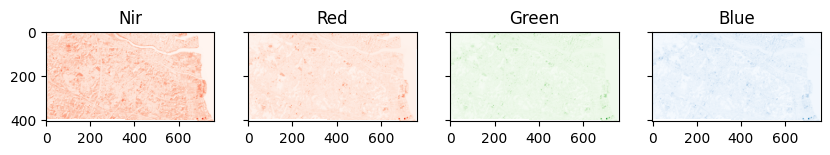

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
ax1.imshow(nirn, alpha = 0.95, cmap='Reds')
ax2.imshow(redn, alpha = 1, cmap='Reds')
ax3.imshow(greenn,  alpha = 1, cmap='Greens')
ax4.imshow(bluen, cmap='Blues')

# Add titles
ax1.set_title("Nir")
ax2.set_title("Red")
ax3.set_title("Green")
ax4.set_title("Blue")

### Processing the data from the input files

In [12]:
# Reading bands from input file
with rio.open(raster_loc) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list
features = []
for i in range(bands):
    features.append('band'+str(i+1))

print('Bands names: ', features)
f_len = len(features)

# Asigning id's to the data points, and converting from gdp to df 

points = gpd.read_file(points_loc)
points = points.assign(id=range(len(points)))
points.to_file(temp_point_loc) 
points_df = pd.DataFrame(points.drop(columns='geometry'))

# lterating over multiband raster
sampled = pd.Series()

# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(raster_loc) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), 
                   columns=features)
df1['id'] = df1.index

data = pd.merge(df1, points_df, on ='id')

# Print the data
print('Sampled Data: \n',data)

# Create X and Y
x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=42)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

# Check for similar points
print(np.intersect1d(X_train, X_test)) 


Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']
Sampled Data: 
       band1   band2   band3   band4   id  labels
0    0.0268  0.0404  0.0228  0.0100    0     1.0
1    0.0284  0.0430  0.0248  0.0111    1     1.0
2    0.0272  0.0402  0.0234  0.0107    2     1.0
3    0.0258  0.0408  0.0231  0.0099    3     1.0
4    0.0248  0.0436  0.0228  0.0107    4     1.0
..      ...     ...     ...     ...  ...     ...
116  0.1066  0.1080  0.1208  0.1368  116     4.0
117  0.1022  0.1092  0.1192  0.1432  117     4.0
118  0.3632  0.3724  0.3644  0.3596  118     4.0
119  0.0849  0.0797  0.0773  0.0918  119     4.0
120  0.0818  0.0902  0.0934  0.1130  120     4.0

[121 rows x 6 columns]
X_train Shape: (96, 4)
X_test Shape: (25, 4)
y_train Shape: (96,)
y_test Shape:(25,)
[0.0107 0.0127 0.0248 0.0268 0.0328 0.0411 0.0412 0.0436 0.0443 0.0604
 0.0778 0.0816 0.0886 0.0916 0.096  0.099  0.1128 0.113  0.118  0.1448
 0.1522 0.1528 0.1822 0.2974]


Bands of input image: 4
Band names: ['band1', 'band2', 'band3', 'band4']


c:\Users\sisly\Documents\HYPSO\code\myenv\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Sampled Data:
     band1   band2   band3   band4  id  labels
0  0.0268  0.0404  0.0228  0.0100   0     1.0
1  0.0284  0.0430  0.0248  0.0111   1     1.0
2  0.0272  0.0402  0.0234  0.0107   2     1.0
3  0.0258  0.0408  0.0231  0.0099   3     1.0
4  0.0248  0.0436  0.0228  0.0107   4     1.0
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
116    4.0
117    4.0
118    4.0
119    4.0
120    4.0
Name: labels, Length: 121, dtype: float64
X_train Shape: (76, 4)
X_test Shape: (25, 4)
y_train Shape: (76,)
y_test Shape: (25,)

Validation Set Results:
Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.

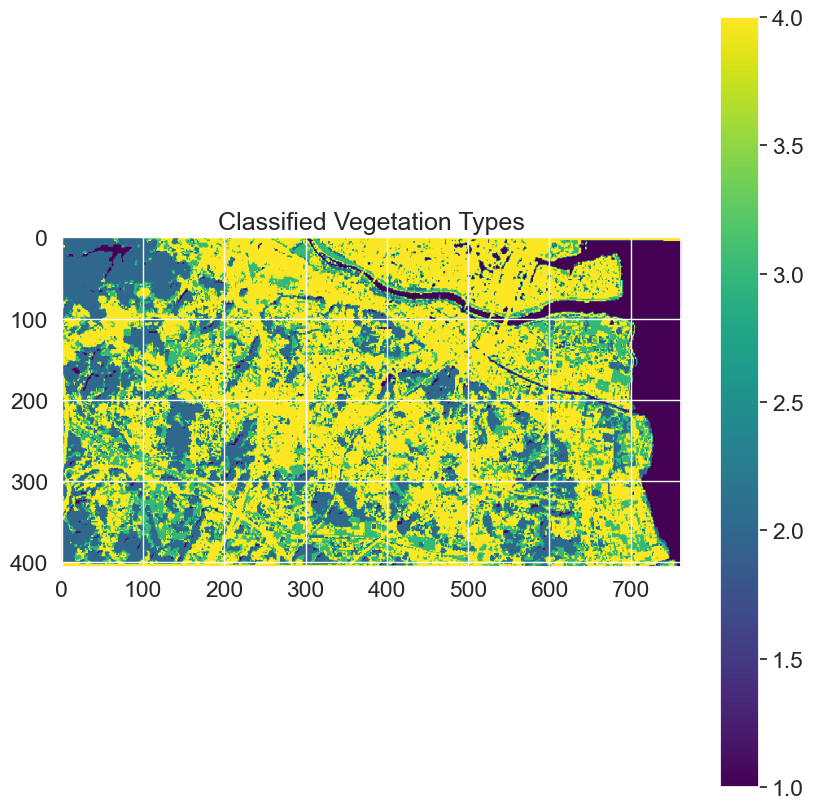

Classified image saved to materials/classified_image.tif


c:\Users\sisly\Documents\HYPSO\code\myenv\lib\site-packages\rasterio\__init__.py:396: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [33]:
import rasterio
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0."""
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

raster_loc = 'materials/rasters/s2image.tif'

with rio.open(raster_loc) as src:
    bands_count = src.count
    print('Bands of input image:', bands_count)
    features = [f'band{i+1}' for i in range(bands_count)]
    print('Band names:', features)

    # Reading bands and normalizing
    bands_data = [normalize(src.read(i + 1, masked=True)) for i in range(bands_count)]

# Step 2: Load the Sample Points
points_loc = 'materials/shapefiles/samples.shp'
temp_point_loc = 'materials/temp/temp_y_points.shp'

# Load sample points into GeoDataFrame
points = gpd.read_file(points_loc)
points = points.assign(id=range(len(points)))
points.to_file(temp_point_loc)  # Save the points with 'id'

# Convert GeoDataFrame to DataFrame
points_df = pd.DataFrame(points.drop(columns='geometry'))

# Step 3: Sample Raster Values at Points
sampled = pd.Series()

with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        with rio.open(raster_loc) as stack_src:
            value = [v for v in stack_src.sample([coords])]
        sampled.loc[siteID] = value

# Reshape the sampled data into a DataFrame
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1 = pd.DataFrame(df1[0].values.tolist(), columns=features)
df1['id'] = df1.index

# Merge sampled data with labels
data = pd.merge(df1, points_df, on='id')
print('Sampled Data:\n', data.head())
print(data['labels'])

# Step 4: Prepare the Data for Machine Learning
X = data.iloc[:, 0:bands_count].values  # Features
Y = data.iloc[:, -1].values             # Labels

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}\ny_test Shape: {y_test.shape}')

# Step 5: Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Validate the model
y_val_pred = rf_classifier.predict(X_val)
print("\nValidation Set Results:")
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))

# Step 6: Evaluate on Test Data
y_test_pred = rf_classifier.predict(X_test)
print("\nTest Set Results:")
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

# Step 7: Apply Model to Entire Image
def classify_raster(image_data, model):
    """Classify raster data using a trained model."""
    flat_pixels = image_data.reshape(-1, image_data.shape[2])
    predictions = model.predict(flat_pixels)
    return predictions.reshape(image_data.shape[:2])

image_stack = np.stack(bands_data, axis=-1)  # Combine normalized bands
classified_image = classify_raster(image_stack, rf_classifier)

# Step 8: Visualize the Classified Image
plt.figure(figsize=(10, 10))
plt.title("Classified Vegetation Types")
plt.imshow(classified_image, cmap='viridis')
plt.colorbar()
plt.show()

# Step 9: Save the Classified Image
output_path = 'materials/classified_image.tif'
with rio.open(
    output_path,
    'w',
    driver='GTiff',
    height=classified_image.shape[0],
    width=classified_image.shape[1],
    count=1,
    dtype=classified_image.dtype
) as dst:
    dst.write(classified_image, 1)

print(f"Classified image saved to {output_path}")

### PCA preparations

In [22]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Visualize decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 0.3, X_train_2d[:, 0].max() + 0.3
y_min, y_max = X_train_2d[:, 1].min() - 0.3, X_train_2d[:, 1].max() + 0.3
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Support Vector Machine (SVM)

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

cName = 'SVM'
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train)


clf_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Classification report
report_svm= classification_report(y_test, clf_pred) # Høy recall ⇒ lavt antall missed cases

# Confusion Matrix
cm_SVM_percent = confusion_matrix(y_test, clf_pred)
cm = confusion_matrix(y_test, clf_pred)



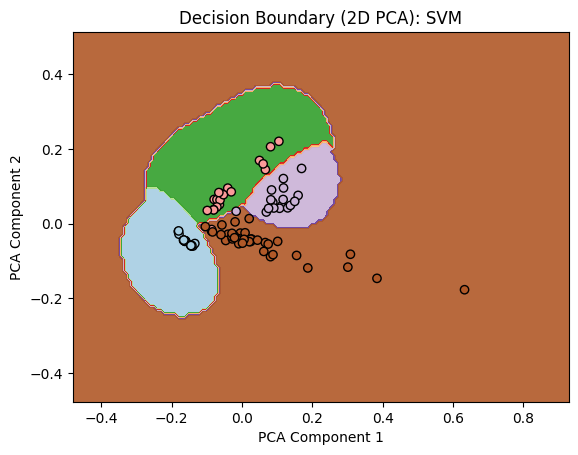

In [24]:
# Train SVM on 2D data
clf_2d = SVC(kernel='rbf', probability=True)
clf_2d.fit(X_train_2d, y_train)

Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.9, cmap=plt.cm.Paired)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision Boundary (2D PCA): SVM')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.axis('tight')

plt.show()


## Random Forest

In [26]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, auc

# Random Forest Classifier
cName_rf = 'RF'
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
clf_pred_rf = clf_rf.predict(X_test)


# Accuracy and Report for Random Forest
acc_rf = accuracy_score(y_test, clf_pred_rf)
report_rf = classification_report(y_test, clf_pred_rf)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, clf_pred_rf)
print(f'Confusion Matrix {cName_rf}: \n', cm_rf)
cm_percent_rf = cm_rf / np.sum(cm_rf)



Confusion Matrix RF: 
 [[5 0 0 0]
 [0 8 0 0]
 [0 0 4 2]
 [0 0 0 6]]
CPU times: total: 250 ms
Wall time: 275 ms


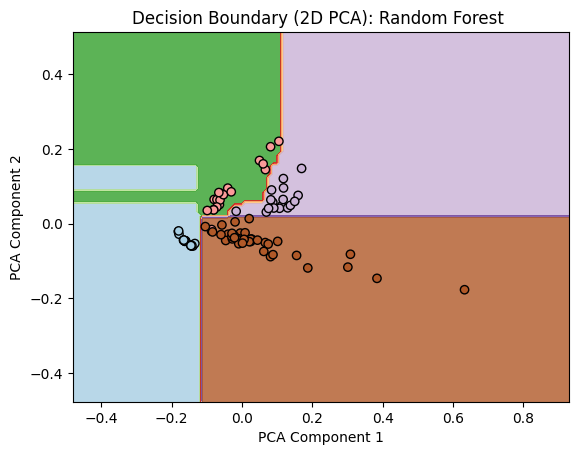

In [27]:
# Train Random Forest on 2D data
 
clf_rf.fit(X_train_2d, y_train)

Z = clf_rf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision Boundary (2D PCA): Random Forest ')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


## Decision Tree

In [28]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

#Decision Tree Classifier
cName_dt = 'DT'
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

clf_pred_dt = clf_dt.predict(X_test)

# Accuracy and Report for Decision Tree
report_dt = classification_report(y_test, clf_pred_dt)

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, clf_pred_dt)
print(f'Confusion Matrix {cName_dt}: \n', cm_dt)
cm_percent_dt = cm_dt / np.sum(cm_dt)



Confusion Matrix DT: 
 [[5 0 0 0]
 [0 8 0 0]
 [0 0 4 2]
 [0 0 2 4]]
CPU times: total: 31.2 ms
Wall time: 25.2 ms


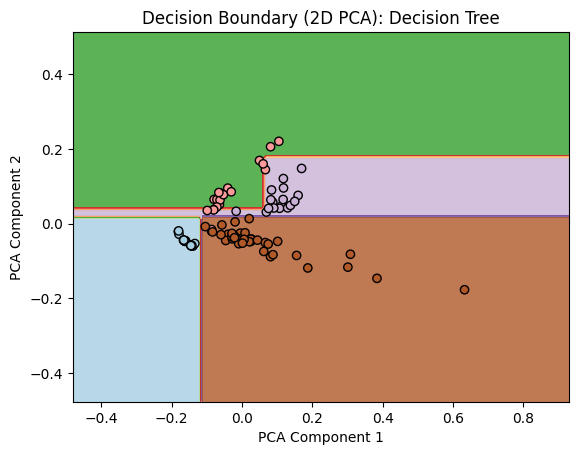

In [29]:
# Train Decision Tree on 2D data
 
clf_dt.fit(X_train_2d, y_train)

Z = clf_dt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision Boundary (2D PCA): Decision Tree')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### Evaluation

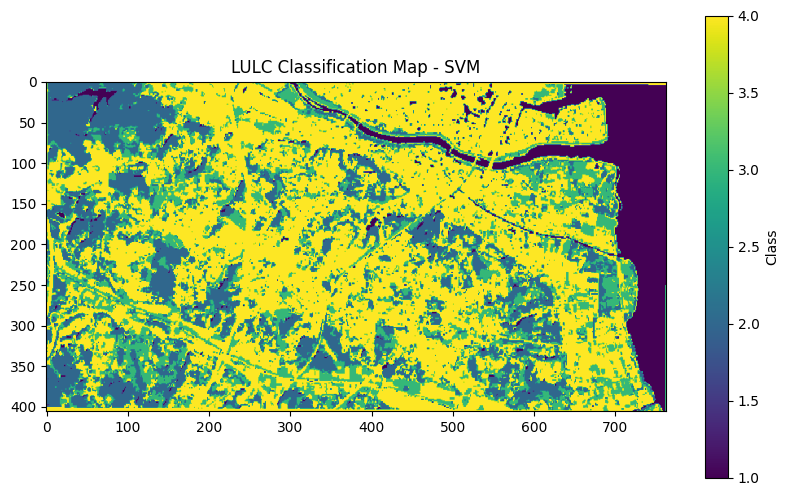

In [30]:
exp_name = f'materials/results/lulc_{cName}.tif'

with rio.open(exp_name) as src:
    # Read the image data
    img = src.read(1)  # Assuming single-band data (you can adjust if multiband)
    
    # Plotting the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='viridis')  # You can change the colormap to any appropriate one
    plt.colorbar(label='Class')
    plt.title(f'LULC Classification Map - {cName}')
    plt.show()

C:\Users\sisly\AppData\Local\Temp\ipykernel_28116\2874534431.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0, 1])  # Adjust layout to make room for the suptitle


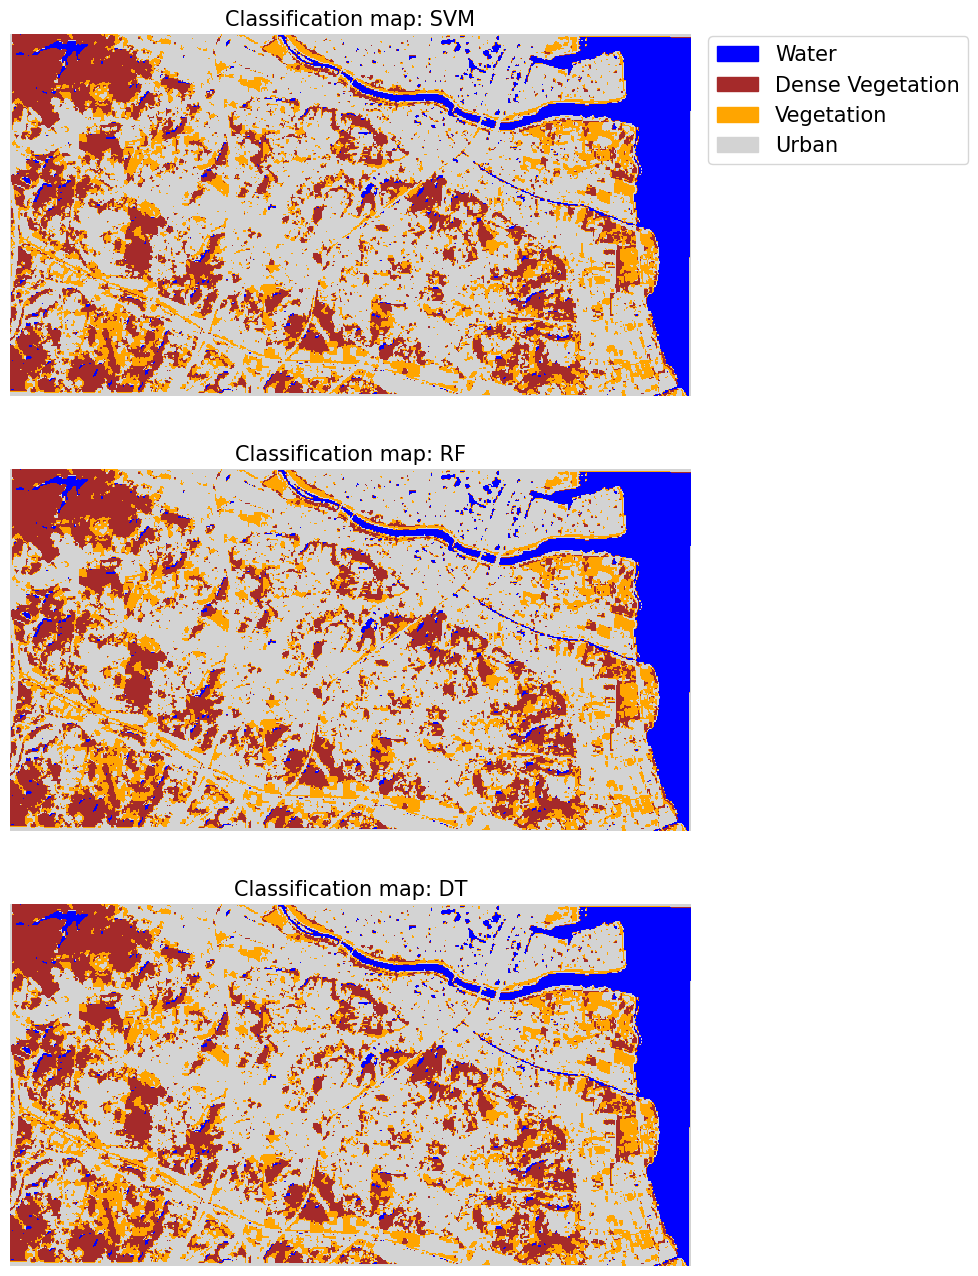

In [32]:
# Classification maps

import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Define LULC names and corresponding colors
lulc_name = ['Water', 'Dense Vegetation', 'Vegetation', 'Urban']
colors = ['blue', 'brown', 'orange', 'lightgrey']  # Custom colors

# Create a custom colormap
cmap = ListedColormap(colors)

# Define file paths for the classification results
ft_file = 'materials/results/lulc_RF.tif'  # Random Forest result
svm_file = 'materials/results/lulc_SVM.tif'  # SVM result
dt_file = 'materials/results/lulc_DT.tif'  # Decision Tree result

# Open all three GeoTIFF files
with rio.open(ft_file) as ft_src, rio.open(svm_file) as svm_src, rio.open(dt_file) as dt_src:
    # Read the classification maps (assuming classification values are 0, 1, 2, 3 for each class)
    ft_img = ft_src.read(1)  # Random Forest classification
    svm_img = svm_src.read(1)  # SVM classification
    dt_img = dt_src.read(1)  # Decision Tree classification

    # Create the figure and subplots (3 subplots)
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 16))  # 1 row, 3 columns

    # Plot SVM classification
    img1 = ax1.imshow(svm_img, cmap=cmap, vmin=1, vmax=len(lulc_name) )
    ax1.set_title('Classification map: SVM', fontsize=15)
    ax1.axis('off')  # Hide axis

    # Plot RF classification
    img2 = ax2.imshow(ft_img, cmap=cmap, vmin=1, vmax=len(lulc_name) )
    ax2.set_title('Classification map: RF', fontsize=15)
    ax2.axis('off')  # Hide axis

    # Plot DT classification
    img3 = ax3.imshow(dt_img, cmap=cmap, vmin=1, vmax=len(lulc_name) )
    ax3.set_title('Classification map: DT', fontsize=15)
    ax3.axis('off')  # Hide axis

    # Add colorbar
    # cbar = fig.colorbar(img2, ax=[ax1, ax2, ax3], orientation='vertical', fraction=0.05, pad=0.05, spacing='uniform')
    # cbar.set_ticks(np.arange(1,5))  # Set colorbar ticks
    # cbar.set_ticklabels(['Water', 'Dense Vegetation', 'Vegetation', 'Impervious'])  # Set colorbar labels

    # Adjust layout and title

    # plt.suptitle('Random Forest vs SVM vs Decision Tree Maps', fontsize=18)

    legend_elements = [Patch(color=colors[i], label=lulc_name[i]) for i in range(len(lulc_name))]
    # fig.legend(handles=legend_elements, fontsize=20)
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.86, 0.885), fontsize=15)
    plt.tight_layout(rect=[0, 0, 0, 1])  # Adjust layout to make room for the suptitle

    # Show the figure
    plt.show()


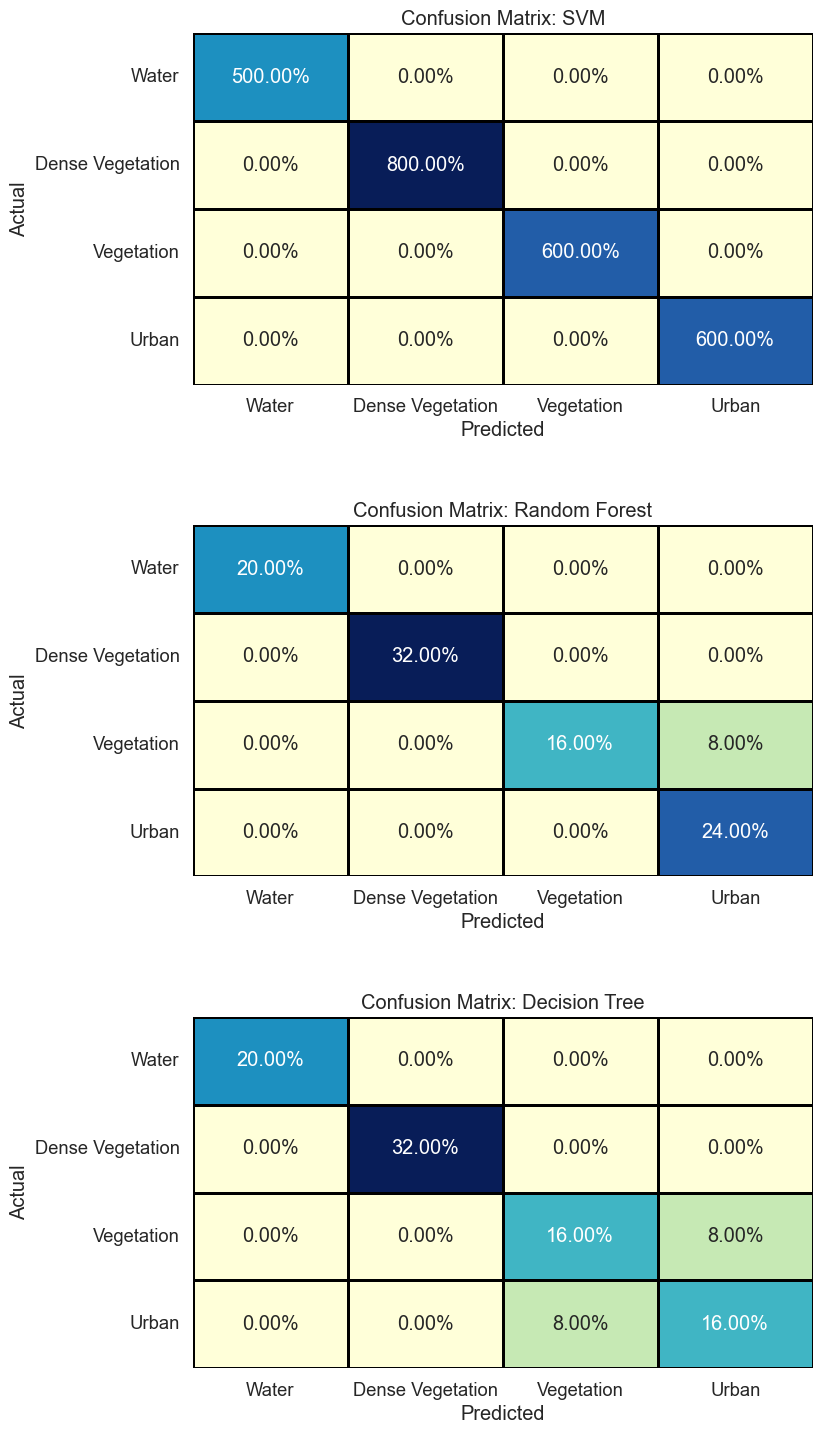

In [34]:
# Confusion Matrices
from numpy import spacing


fig, axes = plt.subplots(3, 1, figsize=(8, 15))
#, constrained_layout=True)
sns.set(font_scale=1.2)

# Plot for SVM
sns.heatmap(cm_SVM_percent,
            annot=True,
            fmt='.2%',
            cmap="YlGnBu",
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            ax=axes[0],
            cbar=False,
            linewidths=2,
            linecolor='black')
axes[0].set_title('Confusion Matrix: SVM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')


# Plot for Random Forest
sns.heatmap(cm_percent_rf,
            annot=True,
            fmt='.2%',
            cmap="YlGnBu",
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            ax=axes[1],
            cbar=False,
            linewidths=2,
            linecolor='black',
            
            )
axes[1].set_title('Confusion Matrix: Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')



# Plot for Decision Tree
sns.heatmap(cm_percent_dt,
            annot=True,
            fmt='.2%',
            cmap="YlGnBu",
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            ax=axes[2],
            cbar=False,
            linewidths=2,
            linecolor='black'
            )
axes[2].set_title('Confusion Matrix: Decision Tree')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

# Show plot
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.2, top=0.1, wspace=2, hspace=2)
plt.subplots_adjust(top=1,hspace=0.4) 

plt.show()

In [35]:
# Classification reports

print('Classification report: SVM\n \n', report_svm)
print('Classification report: RF\n \n', report_rf)
print('Classification report: DT\n \n',report_dt)

Classification report: SVM
 
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         8
         3.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00         6

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Classification report: RF
 
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         8
         3.0       1.00      0.67      0.80         6
         4.0       0.75      1.00      0.86         6

    accuracy                           0.92        25
   macro avg       0.94      0.92      0.91        25
weighted avg       0.94      0.92      0.92        25

Classification report: DT
 
               precision    recall  f1-scor